# Analysis

After running `compare.py` on various sources (chng, nchs, dsew, hhs, quidel), this analysis notebook pinpoints where/when the difference between api and S3 happened.

Read all json files in current dir to a df.

In [19]:
import datetime
import glob
import pandas as pd
import numpy as np
# Create a histogram of the 'signal' column
import matplotlib.pyplot as plt
import matplotlib.dates as md

json_files = glob.glob('./json_files/*.json')

# Read all the JSON files into a list of DataFrames
dfs = [pd.read_json(file) for file in json_files]

# Concatenate all the DataFrames into one
df = pd.concat(dfs, ignore_index=True)
print(df.columns)
df['time_value'] = df['time_value'].fillna(0).astype(int)


Index(['file_name', 'source', 'signal', 'time_value', 'geo_type',
       'dif_row_count', 's3_row_count', 'api_row_count', 'full_dif', 'skip',
       'reason', 'full_diff', 'diff'],
      dtype='object')


In [73]:
def generate_diff_plot(source, df_match, df_diff):
    plt.figure(figsize=(30, 10))
    plt.title(f'S3 files with difference from API vs no diff by {source} signals', fontsize=50)

    
    # row_match = df_match[["signal","s3_row_count"]].groupby(["signal"]).sum().to_dict()["s3_row_count"]
    # match_signals, match_data  = zip(*(sorted(row_match.items())))
    # plt.bar(match_signals, match_data, label='matching', width=0.5)
    if df_diff['diff'].notna().all():
        df_diff["s3_nan_row_count"] = df_diff.loc[:,"diff"].apply(lambda x:x['s3_nan_row_count'])
        
        df_diff["api_nan_row_count"] = df_diff.loc[:,"diff"].apply(lambda x:x['api_nan_row_count'])
        df_diff["diff_val_row_count"] = df_diff["diff"].apply(lambda x:x['num_rows'] - (x['api_nan_row_count'] + x['s3_nan_row_count'])).astype(int)

        api_nan = df_diff[["signal", "api_nan_row_count"]].groupby(["signal"]).sum().to_dict()["api_nan_row_count"]
        s3_nan = df_diff[["signal", "s3_nan_row_count"]].groupby(["signal"]).sum().to_dict()["s3_nan_row_count"]
        val_diff = df_diff[["signal", "diff_val_row_count"]].groupby(["signal"]).sum().to_dict()["diff_val_row_count"]
        
        api_signals, api_data  = zip(*(sorted(api_nan.items())))
        s3_signals, s3_data =  zip(*(sorted(s3_nan.items())))
        val_signals, val_data =  zip(*(sorted(val_diff.items())))
    
        bottom = np.zeros(len(api_signals))
        plt.bar(val_signals, val_data, bottom=bottom, label='val diff', width=0.5)
        plt.bar(api_signals, api_data, bottom=bottom+val_data, label='nan api', width=0.5,)
        plt.bar(s3_signals, s3_data, bottom=bottom+val_data+api_data, label='nan s3', width=0.5,)
        
    # else:
        # diff = df_diff[['signal','dif_row_count']].groupby(["signal"]).sum().to_dict()["diff_val_row_count"]
        # plt.hist(diff,stacked=True, bins=num_signals, label='difference', width=0.5, align="right")
    plt.legend()
    plt.ylim(top=100)
    # Set the labels and title
    plt.xlabel('Signals', fontsize=20)
    plt.ylabel('Number of rows', fontsize=30)

    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
    plt.tick_params(axis='y', which='major', labelsize=25, width=0.5)
    plt.tick_params(axis='x', which='major',  labelsize=25)
    # Display the plot
    plt.show()
    

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_40003/1161579441.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff["s3_nan_row_count"] = df_diff.loc[:,"diff"].apply(lambda x:x['s3_nan_row_count'])
/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_40003/1161579441.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diff["api_nan_row_count"] = df_diff.loc[:,"diff"].apply(lambda x:x['api_nan_row_count'])
/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_40003/1161579

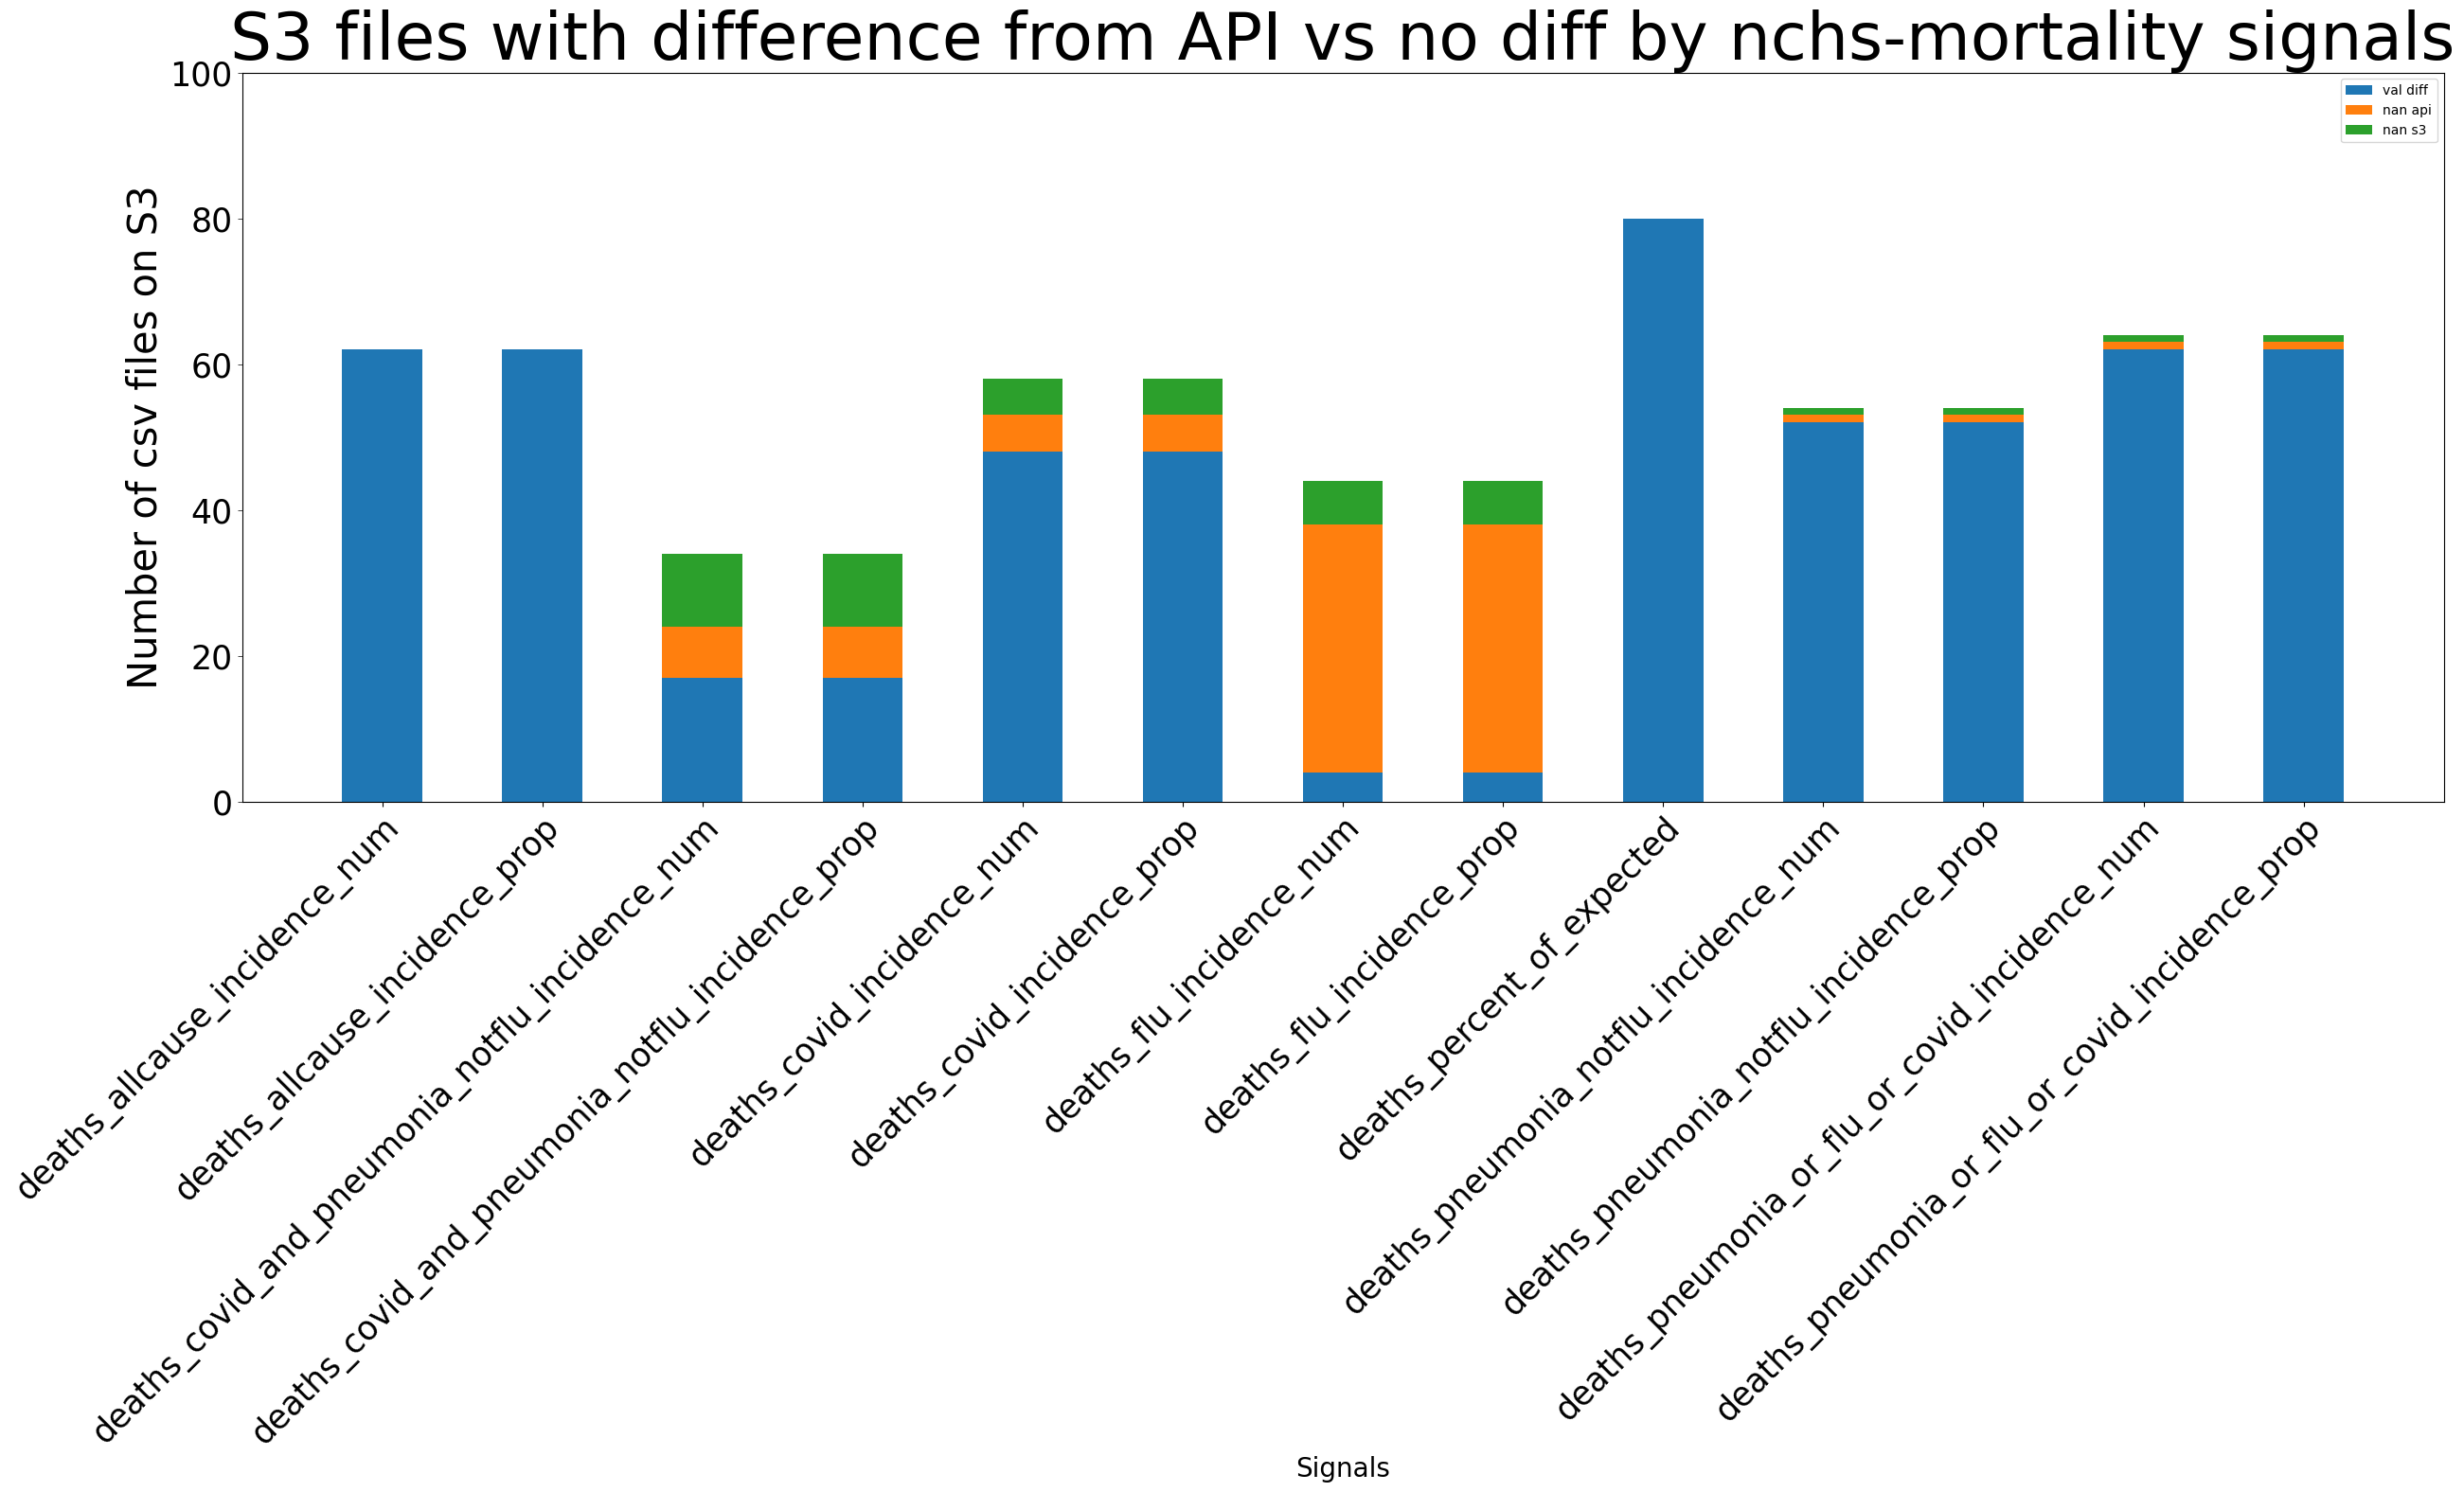

In [74]:
nchs = df[df["source"]=="nchs-mortality"].copy(deep=True)
nchs_diff = nchs[(nchs['dif_row_count']!=0) & (nchs['skip']==False)]
nchs_match = nchs[nchs['dif_row_count']==0]

generate_diff_plot("nchs-mortality", nchs_match, nchs_diff)

In [98]:
def generate_diff_over_time_plot(source, df_diff):
    # Create a plot
    plt.figure(figsize=(20, 5))
    if df_diff['diff'].notna().all():
        df_diff["s3_nan_row_count"] = df_diff.loc[:,"diff"].apply(lambda x:x['num_rows'])
        
        df_diff["api_nan_row_count"] = df_diff.loc[:,"diff"].apply(lambda x:x['api_nan_row_count'])
        df_diff["diff_val_row_count"] = df_diff["diff"].apply(lambda x:x['num_rows'] - (x['api_nan_row_count'] + x['s3_nan_row_count'])).astype(int)
    
        api_nan = df_diff[["time_value", "api_nan_row_count"]].groupby(["time_value"]).sum().to_dict()["api_nan_row_count"]
        s3_nan = df_diff[["time_value", "s3_nan_row_count"]].groupby(["time_value"]).sum().to_dict()["s3_nan_row_count"]
        val_diff = df_diff[["time_value", "diff_val_row_count"]].groupby(["time_value"]).sum().to_dict()["diff_val_row_count"]
        
        api_signals, api_data  = zip(*(sorted(api_nan.items())))
        s3_signals, s3_data =  zip(*(sorted(s3_nan.items())))
        val_signals, val_data =  zip(*(sorted(val_diff.items())))
    
        bottom = np.zeros(len(api_signals))

        plt.bar(val_signals, val_data, bottom=bottom, label='nan api', width=datetime.timedelta(days=1), color='blue')
        plt.bar(api_signals, api_data, bottom=bottom+val_data, label='nan s3', width=datetime.timedelta(days=1),
                color='orange')
        plt.bar(s3_signals, s3_data, bottom=bottom+val_data+api_data,  label='val diff', width=datetime.timedelta(days=1), color='green')

    else:
        plt.bar(df_diff['time_value'], df_diff['dif_row_count'])
    
    # Set the labels and title
    
    plt.xlabel('Time Value')
    plt.ylabel('Number of Row differences', fontsize=20)
    plt.title(f'Number of Row differences over Time ({source})', fontsize=20)
    plt.legend()

    # Display the plot
    plt.show()
    

/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_40003/592572972.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nchs_diff['time_value'] = nchs_diff['time_value'].astype(str) + '0'
/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_40003/592572972.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nchs_diff['time_value'] = pd.to_datetime(nchs_diff['time_value'], format='%Y%U%w')
/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_40003/515986628.py:5: SettingWithCopyWarning: 
A

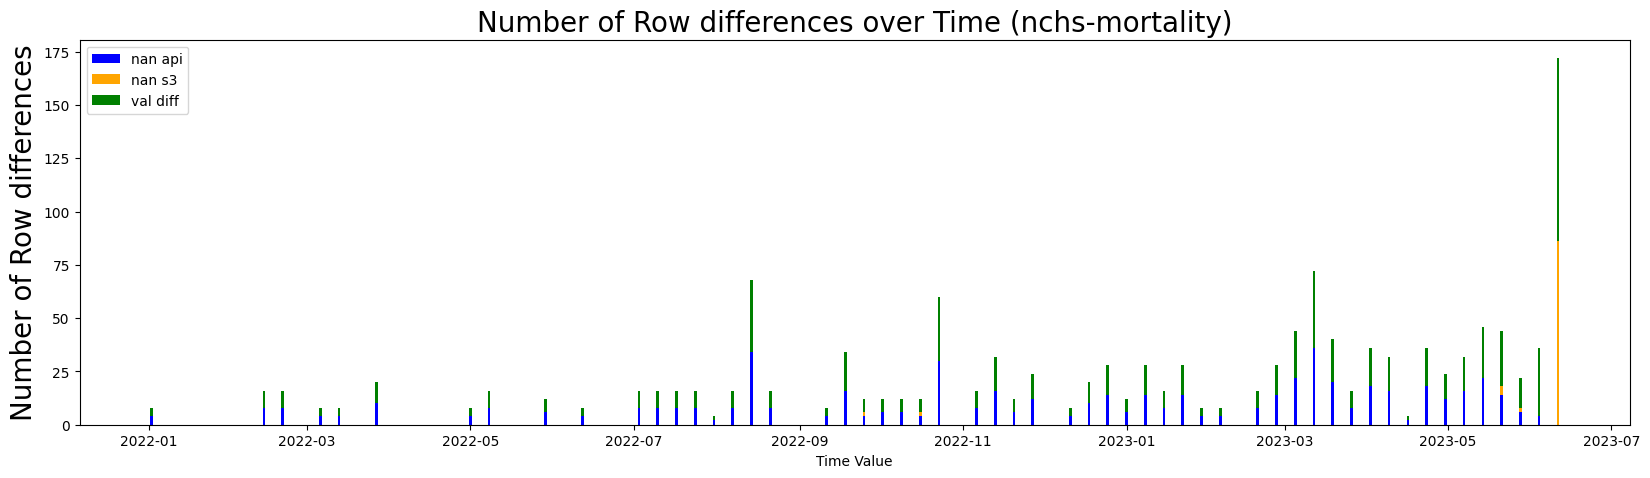

In [99]:
nchs = df[df["source"]=="nchs-mortality"].copy(deep=True)
nchs_diff = nchs[(nchs['dif_row_count']!=0) & (nchs['skip']==False)]

nchs_diff['time_value'] = nchs_diff['time_value'].astype(str) + '0'
# Convert 'time_value' to datetime
nchs_diff['time_value'] = pd.to_datetime(nchs_diff['time_value'], format='%Y%U%w')
generate_diff_over_time_plot("nchs-mortality", nchs_diff)

## General Analysis
After missingness is taken into account, less than 10% of the files have differences.

In [ ]:
print('number of s3 csv files processed by compare.py',len(df))
print('number of s3 csv files with differences found',len(df[df['dif_row_count']!=0]))

## Specific Indicators
#### 1. Quidel
Vast majority of quidel s3 files have all rows matching api equivalent.
Smoothed signals have more differences than non-smoothed signals.
2 big spikes in 2022 and throughout mid 2023. 

In [ ]:
quidel = df[df["source"]=="quidel"].copy(deep=True)
# quidel["s3_nan_row_count"] = quidel["diff"].apply(lambda x:x['s3_nan_row_count'])
# quidel["api_nan_row_count"] = quidel["diff"].apply(lambda x:x['api_nan_row_count'])

In [ ]:
print(f"Files with mismatched rows: {len(quidel[quidel['dif_row_count']!=0])}")
print(f"Files processed: {len(quidel)}")
print(f"Rate of problematic files: {len(quidel[quidel['dif_row_count']!=0])/len(quidel)}")

In [ ]:
quidel_match = quidel[quidel['dif_row_count']==0]
quidel_diff = quidel[quidel['dif_row_count']!=0]
generate_diff_plot("quidel", quidel_match, quidel_diff)

In [ ]:
quidel_diff['time_value'] = pd.to_datetime(quidel_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("quidel", quidel_diff)

#### 2. nchs

Note: This indicator uses its own version of the archive differ, which outputs a different csv structure, causing wrong result in previous analysis.

With that and missingness taken into account, this time we see the indicator has 13% of files being different from its equivalent api result, with the biggest spike in mid 2023.

In [89]:
nchs = df[df["source"]=="nchs-mortality"].copy(deep=True)
nchs_diff = nchs[(nchs['dif_row_count']!=0)& (nchs['skip']==False)]
nchs_match = nchs[nchs['dif_row_count']==0 & (nchs['skip']==False)]
nchs_diff["s3_nan_row_count"] = nchs_diff["diff"].apply(lambda x:x['s3_nan_row_count']).astype(int)
nchs_diff["api_nan_row_count"] = nchs_diff["diff"].apply(lambda x:x['api_nan_row_count']).astype(int)
nchs_diff["diff_val_row_count"] = nchs_diff["diff"].apply(lambda x:x['num_rows'] - (x['api_nan_row_count'] + x['s3_nan_row_count'])).astype(int)
nchs_diff["dif_row_count"] = nchs_diff["diff"].apply(lambda x:x['num_rows']).astype(int)

nan_api_filter = (nchs_diff["api_nan_row_count"] > 0)
nan_s3_filter = (nchs_diff["s3_nan_row_count"] > 0)
diff_val_filter = (nchs_diff["diff_val_row_count"] > 0)



/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_40003/1781558350.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nchs_diff["s3_nan_row_count"] = nchs_diff["diff"].apply(lambda x:x['s3_nan_row_count']).astype(int)
/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipykernel_40003/1781558350.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nchs_diff["api_nan_row_count"] = nchs_diff["diff"].apply(lambda x:x['api_nan_row_count']).astype(int)
/var/folders/s6/ytv8f9z11q32lhh5ksxrp_tm0000gn/T/ipyke

In [90]:
print(f"Files with mismatched rows: {len(nchs[(nchs['dif_row_count']!=0)])}")
print(f"Files processed: {len(nchs)}")
print(f"Rate of problematic files: {len(nchs[nchs['dif_row_count']!=0])/len(nchs)}")
print(f"Total mismatched rows: {nchs_diff['dif_row_count'].sum()}")
print(f"    S3 Rows with NaN: {nchs_diff[nan_s3_filter]['s3_nan_row_count'].sum()}")
print(f"    Api Rows with NaN: {nchs_diff[nan_api_filter]['api_nan_row_count'].sum()}")
print(f"    Rows with diff vales: {nchs_diff[diff_val_filter]['diff_val_row_count'].sum()}")


Files with mismatched rows: 953
Files processed: 7046
Rate of problematic files: 0.1352540448481408
Total mismatched rows: 712
    S3 Rows with NaN: 46
    Api Rows with NaN: 96
    Rows with diff vales: 570


In [ ]:
nchs_diff = nchs[(nchs['dif_row_count']!=0) & (nchs['skip']==False)]
nchs_match = nchs[nchs['dif_row_count']==0]

In [ ]:
generate_diff_plot("nchs-mortality", nchs_match, nchs_diff)

In [ ]:
nchs_diff['time_value'] = nchs_diff['time_value'].astype(str) + '0'
# Convert 'time_value' to datetime
nchs_diff['time_value'] = pd.to_datetime(nchs_diff['time_value'], format='%Y%U%w')
generate_diff_over_time_plot("nchs-mortality", nchs_diff)

#### 3. chng

Around 30% of files have some differences from api.
Two major periods of mismatch:
- Mid 2020 to late 2021
- mid 2023 when the big contract patch happened.

In [ ]:
chng = df[df["source"]=="chng"]

In [ ]:
print(f"Files with mismatched rows: {len(chng[chng['dif_row_count']!=0])}")
print(f"Files processed: {len(chng)}")
print(f"Rate of problematic files: {len(chng[chng['dif_row_count']!=0])/len(chng)}")

In [ ]:
chng_diff = chng[chng['dif_row_count']!=0]
chng_match = chng[chng['dif_row_count']==0]

generate_diff_plot("chng", chng_match, chng_diff)

In [ ]:
chng['time_value'] = pd.to_datetime(chng['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("chng", chng_diff)

#### 4.hhs
Vast majority of files for this indicator match api.
Late 2023 is when we see a spike of mismatch, right before the indicator got retired.


In [ ]:
hhs= df[df["source"]=="hhs"]
# hhs.head(10)

In [ ]:
print(f"Files with mismatched rows: {len(hhs[hhs['dif_row_count']!=0])}")
print(f"Files processed: {len(hhs)}")
print(f"Rate of problematic files: {len(hhs[hhs['dif_row_count']!=0])/len(hhs)}")

In [ ]:
hhs_diff = hhs[hhs['dif_row_count']!=0]
hhs_match = hhs[hhs['dif_row_count']==0]
generate_diff_plot("hhs", hhs_match, hhs_diff)

In [ ]:
# Convert 'time_value' to datetime
hhs_diff['time_value'] = pd.to_datetime(hhs_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("hhs", hhs_diff)

#### 5. dsew
Vast majority of the files all match. 

In [ ]:
dsew = df[df["source"]=="dsew-cpr"]

In [ ]:
print(f"Files with mismatched rows: {len(dsew[dsew['dif_row_count']!=0])}")
print(f"Files processed: {len(dsew)}")
print(f"Rate of problematic files: {len(dsew[dsew['dif_row_count']!=0])/len(dsew)}")

In [ ]:
dsew_diff = dsew[dsew['dif_row_count']!=0]
dsew_match = dsew[dsew['dif_row_count']==0]

generate_diff_plot("dsew", dsew_match, dsew_diff)

In [ ]:
# Convert 'time_value' to datetime
dsew_diff['time_value'] = pd.to_datetime(dsew_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("dsew", dsew_diff)

#### 6. usafacts
Vast majority of files match.
Big spike for super brief periods of time in 2020.

In [ ]:
usafacts = df[df["source"]=="usa-facts"]

In [ ]:
print(f"Files with mismatched rows: {len(usafacts[usafacts['dif_row_count']!=0])}")
print(f"Files processed: {len(usafacts)}")
print(f"Rate of problematic files: {len(usafacts[usafacts['dif_row_count']!=0])/len(usafacts)}")

In [ ]:
usafacts_diff = usafacts[usafacts['dif_row_count']!=0]
usafacts_match = usafacts[usafacts['dif_row_count']==0]

generate_diff_plot("usa-facts", usafacts_match, usafacts_diff)

In [ ]:
# Convert 'time_value' to datetime
usafacts_diff['time_value'] = pd.to_datetime(usafacts_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("usa-facts", usafacts_diff)

#### 7. JHU
Around 20% of fies have mismatch. 
Big outlier spike in early 2023.

In [ ]:
jhu = df[df["source"]=="jhu-csse"]
jhu.head()

In [ ]:
print(len(jhu[jhu['dif_row_count']!=0]))
print(len(jhu))
print(len(jhu[jhu['dif_row_count']!=0])/len(jhu))

In [ ]:
jhu_diff = jhu[jhu['dif_row_count']!=0]
jhu_match = jhu[jhu['dif_row_count']==0]

generate_diff_plot("jhu", jhu_match, jhu_diff)

In [ ]:
# Convert 'time_value' to datetime
jhu_diff['time_value'] = pd.to_datetime(jhu_diff['time_value'], format='%Y%m%d')
generate_diff_over_time_plot("jhu", jhu_diff)